# imports

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## import data

In [3]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

In [4]:
train

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [5]:
valid

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41365,VALIDATION_41366.jpg,CHAILLAN
41366,VALIDATION_41367.jpg,BAROUH
41367,VALIDATION_41368.jpg,MAXENCE
41368,VALIDATION_41369.jpg,HAMELIN


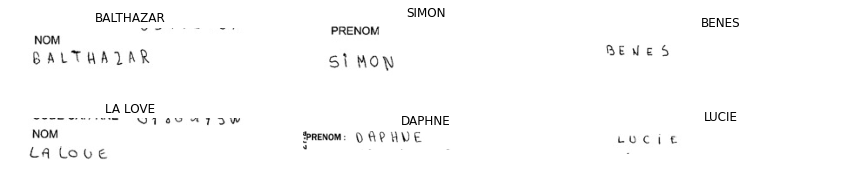

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# cleaning data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [8]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41292 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [9]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [10]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

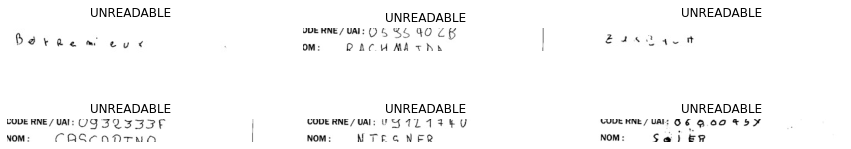

In [11]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [12]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [40]:
# Ensure that we are modifying the original DataFrame
train.loc[:, 'IDENTITY'] = train['IDENTITY'].fillna('').astype(str).str.upper()
valid.loc[:, 'IDENTITY'] = valid['IDENTITY'].fillna('').astype(str).str.upper()


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [14]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

# pre-processing data

In [15]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [16]:
train_size = 30000
valid_size= 3000

In [17]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [18]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [19]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [20]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [21]:
name = 'Team rocket'
print(name, '\n',label_to_num(name))

NUR HIKMAH 
 [13 20 17 28  7  8 10 12  0  7]


In [22]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [23]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [24]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# model building


In [25]:
# Input layer: expects grayscale images of shape (256, 64, 1)
input_data = Input(shape=(256, 64, 1), name='input')

# First Convolutional Block
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner) 
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

# Second Convolutional Block
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  #
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) 
inner = Dropout(0.3)(inner)  

# Third Convolutional Block
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # 128 filters, 3x3 kernel
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner) 

# Reshape layer to prepare for RNN input
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)  # Reshape to (64, 1024)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

# Recurrent Neural Network (RNN) Layers
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)  # Bidirectional LSTM with 256 units, returns sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)  # Another Bidirectional LSTM with 256 units

# Output layer
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner) 
y_pred = Activation('softmax', name='softmax')(inner)  

# Model definition
model = Model(inputs=input_data, outputs=y_pred)  
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

# CTC loss



In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# compile model

In [28]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

# training

In [29]:
with tf.device('/GPU:0'):
    history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                          validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                          epochs=60, batch_size=128)

Epoch 1/60
235/235 [==============================] - 34s 146ms/step - loss: 24.5923 - val_loss: 20.8157
Epoch 2/60
235/235 [==============================] - 33s 140ms/step - loss: 20.0926 - val_loss: 20.1258
Epoch 3/60
235/235 [==============================] - 33s 139ms/step - loss: 19.7169 - val_loss: 19.5593
Epoch 4/60
235/235 [==============================] - 33s 139ms/step - loss: 19.1403 - val_loss: 18.7735
Epoch 5/60
235/235 [==============================] - 33s 140ms/step - loss: 18.1168 - val_loss: 18.0592
Epoch 6/60
235/235 [==============================] - 33s 139ms/step - loss: 16.5599 - val_loss: 15.6201
Epoch 7/60
235/235 [==============================] - 33s 141ms/step - loss: 14.6154 - val_loss: 13.2679
Epoch 8/60
235/235 [==============================] - 33s 141ms/step - loss: 12.5493 - val_loss: 11.0170
Epoch 9/60
235/235 [==============================] - 33s 141ms/step - loss: 10.4718 - val_loss: 8.9708
Epoch 10/60
235/235 [==============================] - 3

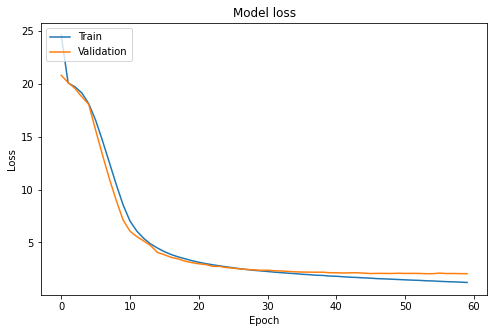

In [30]:
# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(8,5))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the training history
plot_training_history(history)

# model performance

In [31]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [32]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 85.90%
Correct words predicted      : 73.20%


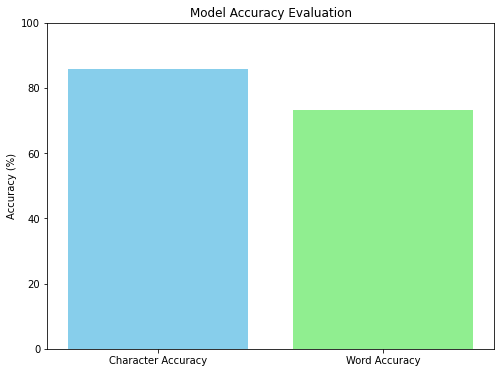

In [ ]:
# Calculate accuracy based on character and word level
correct_char_percent = correct_char * 100 / total_char
correct_word_percent = correct * 100 / valid_size

# Plotting the accuracy with custom colors
plt.figure(figsize=(8, 6))
plt.bar(['Character Accuracy', 'Word Accuracy'], 
        [correct_char_percent, correct_word_percent], 
        color=['red', 'black'])  
plt.ylim(0, 100)
plt.title('Model Accuracy Evaluation')
plt.ylabel('Accuracy (%)')
plt.show()

# Error rates for letters and words.

In [34]:
def calculate_cer(gt_texts, pred_texts):
    """
    Calculate the Character Error Rate (CER) between ground truth texts and predicted texts.
    """
    total_errors = 0
    total_chars = 0
    
    for gt, pred in zip(gt_texts, pred_texts):
        total_errors += edit_distance(gt, pred)
        total_chars += len(gt)
    
    cer = total_errors / total_chars
    return cer

def calculate_wer(gt_texts, pred_texts):
    """
    Calculate the Word Error Rate (WER) between ground truth texts and predicted texts.
    """
    total_errors = 0
    total_words = 0
    
    for gt, pred in zip(gt_texts, pred_texts):
        total_errors += edit_distance(gt.split(), pred.split())
        total_words += len(gt.split())
    
    wer = total_errors / total_words
    return wer

def edit_distance(s1, s2):
    
    if len(s1) < len(s2):
        return edit_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

ground_truths = valid.loc[:valid_size, 'IDENTITY'].tolist()
predictions = prediction

cer = calculate_cer(ground_truths, predictions)
wer = calculate_wer(ground_truths, predictions)

print('Character Error Rate (CER): {:.2f}%'.format(cer * 100))
print('Word Error Rate (WER): {:.2f}%'.format(wer * 100))

Character Error Rate (CER): 7.97%
Word Error Rate (WER): 27.47%


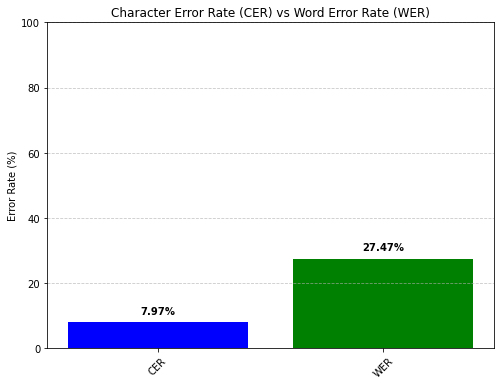

In [ ]:
cer_values = [cer]  # CER value
wer_values = [wer]  # WER value
labels = ['CER', 'WER']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, [cer * 100, wer * 100], color=['red', 'black'])
plt.ylim(0, 100)  # Set y-axis limit from 0% to 100%
plt.ylabel('Error Rate (%)')
plt.title('Character Error Rate (CER) vs Word Error Rate (WER)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([cer * 100, wer * 100]):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

# model testing

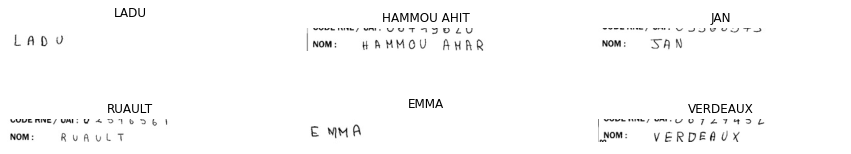

In [36]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(100,106):
    ax = plt.subplot(2, 3, i - 100 + 1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

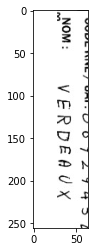

In [37]:
im = cv2.imread('/kaggle/input/handwriting-recognition/test_v2/test/TEST_0020.jpg', cv2.IMREAD_GRAYSCALE)
im = preprocess(im)
plt.imshow(image, cmap='gray')


In [38]:
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
num_to_label(decoded[0])

'VERDEAUX'

# save model

In [39]:
model_final.save('best_model.h5')